# <center>EP2: Performance Study of Mandelbrot Set Computation using OpenMPI with Pthreads and OpenMP</center>
<center>Authors:</center>
<center>Carlos Eduardo Rodrigues da Costa - 9491756</center>
<center>Hamed Panjeh - 9630952</center>
<center>Lucas Martinuzzo Batista - 11930158</center>
</center>

# Sections
- Introduction
- Set Up
- Algorithm Implementation
    - OpenMPI
    - OpenMPI + OpenMP/Pthread Implementation
- Execution
- Loading and Processing
- Results, Analysis and Discussions
    - EP 1 - Review
        - Sequential Execution
        - Comparison between the earlier parallel versions, OpenMP and Pthread, and Sequential
    - EP 2
        - MPI
        - MPI + OpenMP/PThread
        -The Best Parameters
- Conclusion

# Introduction

The aim of the EP is to implement Pthread and OpenMP algorithms with OpenMPI to compute the Mandelbrot set and also evaluate and compare the performance of parallel approaches by executing and measuring their differences.

As a baseline, a sequential version of the program and parallel versions using only OpenMP and Pthread were executed too with fixed number of threads that was obtained on EP 1. In this report we see how Message Passing Interface (MPI) interact with Pthread and OpenMP in terms of performance.

The remaining of this report is divided on the following sections: Set Up, Algorithm Implementation, Execution, Reading and Processing, Analysis, Conclusion. In the first section, Set Up, we describe the machine configuration where all the experiments were executed.

The Algorithm Implementation section talks about the choices we made when implementing each algorithm that may affect the results. 

The Execution section explain how to run the tests. It is optional to run them since the experiments are done and the results are already saved.

The Loading and Processing section consists on functions to read the outputs generated by the program and process them to generate the graphs needed for the analysis.

In the Analysis section we compare the results by ploting the graphs and analysing them.

Last, we conclude our thoughts in the Conclusion section.

# Set Up

The experiments were all executed on a machine with the following configurations:

**SO**: MacOS Big Sur 11.5.1

**CPU**: Intel Core i7-8850H

**Memory**:  16 GB DDR4 2400 MHz

**Graphics Card**: Radeon Pro 560X 

**Storage**: APPLE SSD AP0512M

## Algorithm Implementation

### OpenMPI
In MPI implementation of Mandelbrot fractal we use the approach of Point-to-point communication which messages are sent between two kinds of processes, the first one, RANK 0, and the ones that execute the job. The former is not responsible for doing the job, it shares data. In this implementaion there is a need to at least two processes. One for RANK 0 and the other as the only worker.

We introduced the variable $num\_process$ as the number of processes. RANK 0 is the main process while the others ($num\_process-1$) processes (RANK > 0) are the workers.

The main task, the construction of the image, is divided between the available workers, such as each part of the image, $num\_rows=\frac{image\_size}{num\_process-1}$,  is shared by process RANK 0. The variable $num\_rows$ contains the number of lines that each worker will receive to build the Mandelbrot Fractal. In the case the division has a remainder, i.e. the remainder of the division $image\_size$ and the number of $num\_process-1$ is greater than zero, the variable $mod\_row$ is created to contain the remainder.

The process of RANK 0 sends the initial and final line of the fractal image that each worker will have to calculate, and receives the result of the jobs executed by them in a vector form, $result\_array$. 

Each worker will calculate image\_size \ast num\_rows points of the image, relative to the fractal, calculating the color values for all the columns of the lines it has been given. After finishing the execution, each worker sends to the master a vector containing the values for each point of the calculated image, in addition to the initial and final position.

After that, the RANK 0 process is responsible for updating the RGB buffer and creating the image. If there is $mod\_row\neq 0$, it is also responsible for executing the remainder part, it will calculate the color values for the $mod\_row \ast image\_size$ endpoints of the image.

Note:

We implemented the aforementioned algorithm to share the jobs among workers using RANK 0 process. E.g: when we run **mpirun -np 2** there is actually only one worker and we run **mpirun -np 3** there is actually two workers. 

In order to check performance of mpi with 1 process, an if-statement is responsible to check that if the input in the command line is -np 1 then the single process which is RANK 0 is responsible for the all work since there is not worker anymore.

### OpenMPI + OpenMP/Pthread Implementation

In implementating the hybrid programs, each worker will divides its job into threads, by using *#pragma omp parallel for* for OpenMP Implementation and *pthread_create* method in the Pthread Implementation. Therefore, RANK 0 will split the image to be calculated by the workers and each worker will split its job into its available threads.

# Execution

To execute the program and generate the experiments, run the *run_measurements2.sh* file on the **src** folder.

The analysis presented on this report are using the results that we obtained and saved on **results_ep2** folder.

# Loading and Processing

In this section all the libraries needed for the report are loaded and the functions implemented. The output of the *mandelbrot_seq.c*, *mandelbrot_pth.c* and *mandelbrot_omp.c* are load to memory.

## Load Libraries

In [1]:
import pandas as pd ##Pandas version must be 0.25 or above
import numpy as np
import seaborn as sns
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('default')

## Read CSVs

In [2]:
#EP1 experiments repeated
seq_df = pd.read_csv("results_ep2/mandelbrot_seq_ep2/triple_spiral.log",sep=";", names=["alloc_write_time", "compute_time", "full_time"])
pth_df = pd.read_csv("results_ep2/mandelbrot_pth_ep2/triple_spiral.log",sep=";", names=["compute_time","n_process", "n_threads"])
omp_df = pd.read_csv("results_ep2/mandelbrot_omp_ep2/triple_spiral.log",sep=";", names=["compute_time","n_process", "n_threads"])
#MPI experiments
mpi_pth_df = pd.read_csv("results_ep2/mandelbrot_mpi_pth/triple_spiral.log",sep=";", names=["compute_time","n_process", "n_threads"])
mpi_omp_df = pd.read_csv("results_ep2/mandelbrot_mpi_omp/triple_spiral.log",sep=";", names=["compute_time","n_process", "n_threads"])
mpi_df = pd.read_csv("results_ep2/mandelbrot_mpi/triple_spiral.log",sep=";", names=["compute_time","n_process", "n_threads"])

print("Loaded")

Loaded


## Auxiliary Functions

In [3]:
#Calculate the confidence interval of an array of values
def confidenceInterval(x):
    return sms.DescrStatsW(x).tconfint_mean()

#Compute the mean and the confidence interval (min,max) of all the sequential times for each image size,
#returns an DataFrame.
def groupSequentialByImageSize(seq_df):
    seq_m_df =  seq_df.groupby(lambda _ : True).agg(
        alloc_write_time = ('alloc_write_time','mean'),
        compute_time = ('compute_time','mean'),
        full_time = ('full_time','mean'),
        alloc_write_confint = ('alloc_write_time',confidenceInterval),
        compute_confint = ('compute_time',confidenceInterval),
        full_confint = ('full_time',confidenceInterval)
    )
    minimo, maximo = separateConfidenceInterval(seq_m_df['alloc_write_confint'])
    seq_m_df['alloc_write_confint_min'] = minimo
    seq_m_df['alloc_write_confint_max'] = maximo
    minimo, maximo = separateConfidenceInterval(seq_m_df['compute_confint'])
    seq_m_df['compute_confint_min'] = minimo
    seq_m_df['compute_confint_max'] = maximo
    minimo, maximo = separateConfidenceInterval(seq_m_df['full_confint'])
    seq_m_df['full_confint_min'] = minimo
    seq_m_df['full_confint_max'] = maximo
    seq_m_df.drop(columns=['alloc_write_confint','compute_confint','full_confint'],inplace=True)
    return seq_m_df

def separateConfidenceInterval(list_of_tuples):
    return zip(*list_of_tuples)

def diffConfidenceInterval(x):
    confidence_interval = sms.DescrStatsW(x).tconfint_mean()
    minimo, maximo = confidence_interval
    return maximo - minimo

def groupParallelBySizeThread(par_df):
    par_m_df = par_df.groupby(['n_process','n_threads']).agg(
        compute_time = ('compute_time','mean'),
        compute_confint = ('compute_time',confidenceInterval)
    )
    minimo, maximo = separateConfidenceInterval(par_m_df['compute_confint'])
    par_m_df['compute_confint_min'] = minimo
    par_m_df['compute_confint_max'] = maximo
    par_m_df.drop(columns=['compute_confint'],inplace=True)
    #par_m_df['n_threads'] = par_m_df['n_threads'].astype(str)
    return par_m_df

def differenceBetweenParallel(df_1,df_2):
    df = df_1.copy()
    df['compute_confint_min'] = df['compute_time'] - df['compute_confint_min']
    df['compute_confint_max'] = df['compute_confint_max'] - df['compute_time']
    df['compute_confint_min_2'] = df_2['compute_time'] - df_2['compute_confint_min']
    df['compute_confint_max_2'] = df_2['compute_confint_max'] - df_2['compute_time']
    df['compute_time'] = df['compute_time'] - df_2['compute_time']
    df['compute_confint_min'] = df.apply(lambda x: math.sqrt(pow(x['compute_confint_min'],2) + pow(x['compute_confint_min_2'],2)),axis=1)
    df['compute_confint_min'] = df['compute_time'] - df['compute_confint_min']
    df['compute_confint_max'] = df.apply(lambda x: math.sqrt(pow(x['compute_confint_max'],2) + pow(x['compute_confint_max_2'],2)),axis=1)
    df['compute_confint_max'] = df['compute_confint_max'] - df['compute_time']
    return df.drop(columns=['compute_confint_min_2','compute_confint_max_2'])

In [4]:
def plot_sequential(seq_df,title):
    time = seq_df[['alloc_write_time','compute_time','full_time']]
    confint_min = seq_df[['alloc_write_confint_min',
                         'compute_confint_min',
                         'full_confint_min']]
    confint_max = seq_df[['alloc_write_confint_max',
                         'compute_confint_max',
                         'full_confint_max']]
    time = time.values[0]
    confint_min = confint_min.values[0]
    confint_max = confint_max.values[0]
    df = pd.DataFrame({'time': ["Allocation + Write","Computation","Full"],
                       'values': time,
                       'ci_min': confint_min,
                       'ci_max': confint_max})
    err = [df['values'] - df['ci_min'], df['ci_max'] - df['values']]
    ax = sns.barplot(x='values',y='time',data=df,color='blue')
    ax.set(xlabel='Average Execution Time (s)',ylabel=None,title='Comparing the time between different parts of the Sequential Execution')
    plt.errorbar(x=df['values'],y=df['time'],xerr=err,fmt='none',color='red')
    ax.grid()
    plt.show()
    return

def plot_sequential_simple_parallel(seq_df,omp_df,pth_df,title):
    time = [seq_df['compute_time'].values[0],
               omp_df['compute_time'].values[0],
               pth_df['compute_time'].values[0]
           ]
    confint_min = [seq_df['compute_confint_min'].values[0],
                      omp_df['compute_confint_min'].values[0],
                      pth_df['compute_confint_min'].values[0]
                  ]
    confint_max = [seq_df['compute_confint_max'].values[0],
                      omp_df['compute_confint_max'].values[0],
                      pth_df['compute_confint_max'].values[0]
                     ]
    df = pd.DataFrame({'execution': ["Sequential","OpenMP","PThread"],
                       'values': time,
                       'ci_min': confint_min,
                       'ci_max': confint_max})
    err = [df['values'] - df['ci_min'], df['ci_max'] - df['values']]
    ax = sns.barplot(x='values',y='execution',data=df,color='blue')
    ax.set(xlabel='Average Execution Time (s)',ylabel=None,title='Comparison between the earlier parallel versions, OpenMP and Pthread, and Sequential')
    plt.errorbar(x=df['values'],y=df['execution'],xerr=err,fmt='none',color='red')
    ax.grid()
    plt.show()
    return

def plot_all(seq_df,omp_df,pth_df,mpi_df,mpi_omp_df,mpi_pth_df,title):
    time = [seq_df['compute_time'].values[0],
               omp_df['compute_time'].values[0],
               pth_df['compute_time'].values[0],
               mpi_df['compute_time'].values[0],
               mpi_omp_df['compute_time'].values[0],
               mpi_pth_df['compute_time'].values[0]
           ]
    confint_min = [seq_df['compute_confint_min'].values[0],
                      omp_df['compute_confint_min'].values[0],
                      pth_df['compute_confint_min'].values[0],
                      mpi_df['compute_confint_min'].values[0],
                      mpi_omp_df['compute_confint_min'].values[0],
                      mpi_pth_df['compute_confint_min'].values[0]
                  ]
    confint_max = [seq_df['compute_confint_max'].values[0],
                      omp_df['compute_confint_max'].values[0],
                      pth_df['compute_confint_max'].values[0],
                      mpi_df['compute_confint_max'].values[0],
                      mpi_omp_df['compute_confint_max'].values[0],
                      mpi_pth_df['compute_confint_max'].values[0]
                     ]
    df = pd.DataFrame({'execution': ["Sequential","OpenMP","PThread","MPI","MPI+OMP","MPI+PTH"],
                       'values': time,
                       'ci_min': confint_min,
                       'ci_max': confint_max})
    err = [df['values'] - df['ci_min'], df['ci_max'] - df['values']]
    ax = sns.barplot(x='values',y='execution',data=df,color='blue')
    ax.set(xlabel='Average Execution Time (s)',ylabel=None,title=title)
    plt.errorbar(x=df['values'],y=df['execution'],xerr=err,fmt='none',color='red')
    ax.grid()
    plt.show()
    return

def plot_mpi(mpi_df,title):
    df = mpi_df.reset_index().copy()
    df['n_process'] = df['n_process'].astype(str)
    err = [df['compute_time'].values - df['compute_confint_min'].values,
           df['compute_confint_max'].values - df['compute_time'].values]
    ax = sns.lineplot(x='n_process',y='compute_time',data=df,color='blue')
    ax.set(ylabel='Average Execution Time (s)',xlabel='Number of Processes',title=title)
    plt.errorbar(y=df['compute_time'],x=df['n_process'],yerr=err,fmt='none',color='red')
    ax.grid()
    plt.show()
    
def plot_mpi_parallel(mpi_other_df,title,conf_int=True):
    df = mpi_other_df.reset_index().copy()
    df['n_process'] = df['n_process'].astype(str)
    df['N. of Threads'] = df['n_threads'].astype(str)
    err = [df['compute_time'].values - df['compute_confint_min'].values,
           df['compute_confint_max'].values - df['compute_time'].values]
    ax = sns.lineplot(x='n_process',y='compute_time',hue='N. of Threads',data=df,color='blue')
    ax.set(ylabel='Average Execution Time (s)',xlabel='Number of Processes',label='N. of Threads',title=title)
    if(conf_int):
        plt.errorbar(y=df['compute_time'],x=df['n_process'],yerr=err,fmt='none',color='red')
    ax.grid()
    plt.show()

## Compute Mean and Confidence Interval

In [5]:
#EP1
seq_df = groupSequentialByImageSize(seq_df)
pth_df = groupParallelBySizeThread(pth_df)
omp_df = groupParallelBySizeThread(omp_df)

#EP2
mpi_pth_df = groupParallelBySizeThread(mpi_pth_df)
mpi_omp_df = groupParallelBySizeThread(mpi_omp_df)
mpi_df = groupParallelBySizeThread(mpi_df)
mpi_dif_df = mpi_pth_df - mpi_omp_df
print("Executed")

Executed


# Analysis
The following subsections present plots focusing on different aspects on the experiment.

**Observation**: All the tests and analysis were made on the Triple Spiral Region with image size fixed on 4096x4096 px as demanded on the EP.

## EP1 - Review

### Sequential Execution

First, lets remember the time consumed on allocating memory and writing the image to file. As we can see below, the **computation** time of Mandelbrot on the Triple Spiral Region is about 7 times larger than the **alocation + writing to file** time, which takes about 3 seconds.

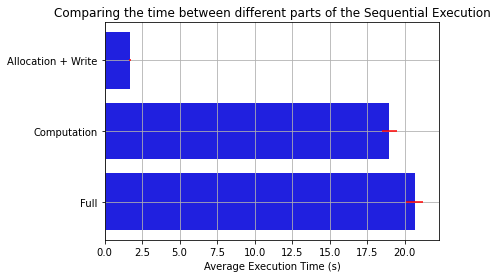

In [6]:
plot_sequential(seq_df,title='Comparing The Time Between Different Parts of the Sequential Execution')

### Comparison between the earlier parallel versions, OpenMP and Pthread, and Sequential

From EP 1, we noticed that the program doesn't perform much better with more than 8 threads for both OpenMP and Pthread version, as shown below.

<img src=./img/plot_nThread_par_ts_4096.png>

Now let's compare the computation time between those parallel versions with 8 threads and the Sequential one.

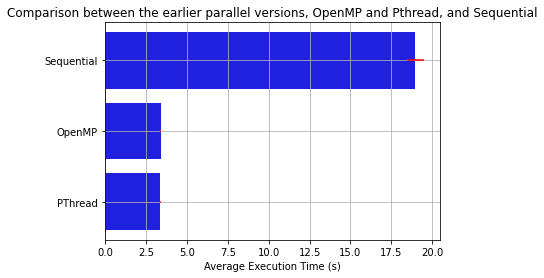

In [7]:
plot_sequential_simple_parallel(seq_df,omp_df,pth_df,
                                title="Comparison Between the Earlier Parallel Versions\nOpenMP and Pthread, and Sequential")

We can notice that OpenMP and PThread are about 6 times faster than the sequential execution, taking about 4 seconds to execute.

## EP2 
Now that we reviewed the results from EP 1, we can focus on EP 2 experiments. 

### MPI
The first experiment is to determine the best number of processes for pure MPI version.

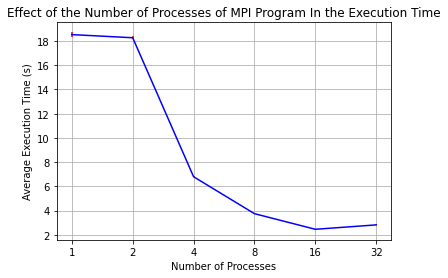

In [8]:
plot_mpi(mpi_df,'Effect of the Number of Processes of MPI Program In the Execution Time')

Note that when we set *-np 2*, only 1 process is responsible for executing the job. That happens because one process (RANK 0) is involved in sharing data and point to point communication is applied. Therefore running either 1 or 2 processes gives approximately the same results, as shown above. 

We can observe that the execution time curve starts to flatten as the number of processes grows, starting with 4 processes. After 16 proccesses we don't gain performance anymore. This is due nature of the experiment, since its very expensive and the CPU  is not able to execute all parts of the process in parallel, making some processes idle until the scheduler decides to execute them. Considering the performance gains per process, increasing the number of process from 1 to 16 drops significantly the execution time.

### MPI + OpenMP/PThread
The following experiments are to investigate the best combination of number of processes and threads for MPI + OpenMP and MPI + PThread.

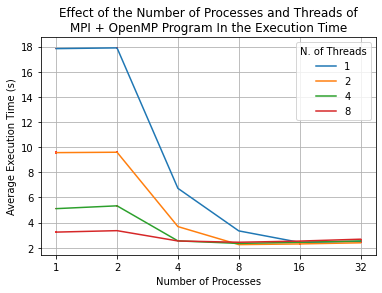

In [9]:
plot_mpi_parallel(mpi_omp_df,'Effect of the Number of Processes and Threads of\nMPI + OpenMP Program In the Execution Time')


The graph above shows that after 8 processes the execution time slowly starts to increase for all programs except the one with a single thread. Since the objective of this EP is to find the best parameters in a hybrid parallel environment considering more than one thread (otherwise it not hybrid), therefore 8 processes is the best parameter even if it does not have the best time in case of only 1 thread.

Since we chose 8 processes as the best parameter, we gonna choose the number of threads by fixing the number of processes at 8. Comparing the number of threads on the result, we observe that 2 threads are enough to obtain the optimum computation time.

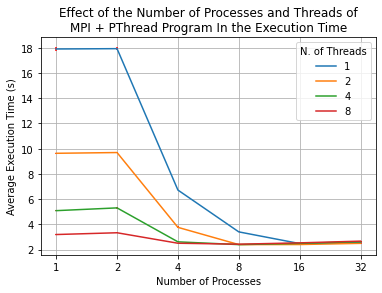

In [10]:
plot_mpi_parallel(mpi_pth_df,'Effect of the Number of Processes and Threads of\nMPI + PThread Program In the Execution Time')

We can see that MPI + Pthread has the same behavior (and almost the same values) of MPI + OpenMP. Therefore we also choose 8 processes and 2 threads as the best parameters.

To confirm that the time obtained on MPI + OpenMP is almost the same of MPI + PThread, we plotted below the difference between the average time on those executions.

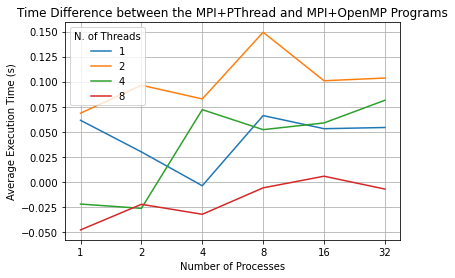

In [11]:
plot_mpi_parallel(mpi_dif_df,'Time Difference between the MPI+PThread and MPI+OpenMP Programs',conf_int=False)

Since the difference calculated was average execution time of MPI+PThread minus average execution time of MPI+OpenMP, the positive values indicates that the Pthread hybrid version is faster than OpenMP, and the negative values indicates the opposite.

In general, in hybrid algorithms we can see that PThread version is faster than OpenMP version. The exceptions are 8 threads in all cases except 16 processes and 4 threads when the number of processes is set to 1 or 2.

It is important to notice even though the the are some fluctuations between the two algorithms, the maximum difference is only 0.15 seconds, so both of them have very similar performance.

### The Best Parameters

On the subsections above we have decided that the best parameters are:
- Number of Processes for MPI alone: 16
- Number of Processes for MPI with OpenMP/PThread: 8
- Number of Threads for MPI with OpenMP/PThread: 2

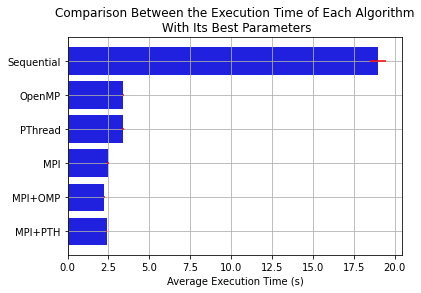

In [13]:
mpi_p = 16
mpi_omp_p = 8
mpi_omp_t = 2
mpi_pth_p = 8
mpi_pth_t = 2
best_mpi = mpi_df.loc[mpi_p]
best_mpi_omp = mpi_omp_df.loc[mpi_omp_p,mpi_omp_t].to_frame().T
best_mpi_pth = mpi_pth_df.loc[mpi_pth_p,mpi_pth_t].to_frame().T
title = "Comparison Between the Execution Time of Each Algorithm\n With Its Best Parameters"
plot_all(seq_df,omp_df,pth_df,best_mpi,best_mpi_omp,best_mpi_pth,title)

We observed that MPI alone is faster than Pthread and OpenMP. When combining those implementations,  MPI with OpenMP and Pthread, the combination show even better performance than the non-hybrid parallel algorithms. We also notice that, in our experiments, the MPI + OpenMP algorithm have showed the best performance.

# Conclusion

From EP 1, we concluded that the parallel algorithms, Pthreads and OpenMP, are more optimized than the sequential algorithm in terms of computation time. Now we see that combining MPI with the former parallel implementations speeds up the execution even if a little bit.

Comparing the parallel algorithms, despite some minor differences, both OpenMP and PThread with MPI have nearly the same computation time on all the experiments.

We also have learned that MPI is more flexible to implement different approaches, despite its complexity. 